# UGW Tutorial

In this tutorial, we will examine how to use Gromov-Wasserstein (GW) and unbalanced Gromov-Wasserstein (UGW) to align a CITE-seq dataset, which has co-assayed antibody and gene expression data on 7985 human/mouse blood cells. We select 1000 human samples from this dataset, and split the data into two matrices: one that contains antibody information on these samples and another that contains gene expression information on the same samples. The goal in this tutorial (as well as UCOOT) will be to recover which sample matches with which sample using optimal transport. So, we are trying to recover a 1-1 mapping that we know exists.

```{note}
Before beginning this tutorial, note that it serves more as an introduction to UCOOT by showing a specific application (UGW), as well as setting up intuition for AGW later on. UCOOT is, in some ways, a generalized version of UGW, and UGW can be directly recovered by making the right choices for the inputs to UCOOT. So, if you want a more detailed tutorial of a slightly more general version, go to the UCOOT tutorial. This tutorial goes into a little bit more detail on the specifics of each hyperparameter, but leaves some of the potential steps to the UCOOT tutorial.
```

```{tip}
If you have not yet configured a SCOT+ directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virual environment, continue on here.

If you aren't sure what any of the parameters for setting up a Solver object mean, try our setup tutorial for getting used to using the tool. We use many of the default parameters for this tutorial.

If you are unsure what some of the notation means throughout the rest of this document, try reading our optimal transport theory section to get more comfortable.

If you are already comfortable with UGW, try moving on to our UCOOT tutorial.
```

### Data download

If you wish to work with the raw PBMC_ADT and PBMC_RNA files from the CITE-seq dataset (we will use the mostly preprocessed ones), run the following commands in the terminal in the root directory of this tutorial repository:

<center> sh ./download_scripts/CITEseq_download.sh </center>

If you download the code manually instead, make sure to produce the same file structure - i.e., there should be a data directory with a CITEseq subdirectory containing your csv files. This folder should already be populated with our two preprocessed datasets if you use the given script.

### Preprocessing

We will start with some mild preprocessing, such as loading the preprocessed datasets into variables local to this notebook. We begin by setting up pytorch. Use this as is, unless you would like to try a different device.

In [1]:
import torch
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.1.0
CUDA available: False
CUDA version: None
CUDNN version: None


In these tutorials, we omit the exact preprocessing steps for this dataset. However, if you would like to replicate the steps in the appendix of Tran et al., implement your preprocessing of the raw datasets here. Use the shape attribute for ndarrays/dataframes/anndata to get a sense for how large these datasets are.

In [2]:
%%capture
from scotplus.solvers import SinkhornSolver
from scotplus.utils.alignment import compute_graph_distances, get_barycentre, FOSCTTM
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import normalize
plt.rcParams['font.family'] = 'Helvetica Neue'

adt_raw = sc.read_csv("./data/CITEseq/citeseq_adt_normalized_1000cells.csv")
rna_raw = sc.read_csv("./data/CITEseq/citeseq_rna_normalizedFC_1000cells.csv")
adt_feat_labels=["CD11a","CD11c","CD123","CD127-IL7Ra","CD14","CD16","CD161","CD19","CD197-CCR7","CD25","CD27","CD278-ICOS","CD28","CD3","CD34","CD38","CD4","CD45RA","CD45RO","CD56","CD57","CD69","CD79b","CD8a","HLA.DR"]

# note that the two PTPRC columns are exactly equal; PTPRC is associated with both CD45RA and CD45RO
rna_feat_labels=["ITGAL","ITGAX","IL3RA","IL7R","CD14","FCGR3A","KLRB1","CD19","CCR7","IL2RA","CD27","ICOS","CD28","CD3E","CD34","CD38","CD4","PTPRC","PTPRC","NCAM1","B3GAT1","CD69","CD79B","CD8A","HLA-DRA"] 
samp_labels = ['Cell {0}'.format(x) for x in range(adt_raw.shape[1])]

```{note}
Throughout this notebook, we examine 25 selected gene-antibody feature pairs. We'll sometimes refer to our RNA dataset as $X$ and our ADT dataset as $Y$, to be a bit more general in our language.
```

In [3]:
# l2 normalization of both datasets, which we found to help with single cell applications
adt = pd.DataFrame(normalize(adt_raw.X.transpose()))
rna = pd.DataFrame(normalize(rna_raw.X.transpose()))

# annotation of both domains
adt.index, adt.columns = samp_labels, adt_feat_labels
rna.index, rna.columns = samp_labels, rna_feat_labels


Now that we have our data, we visualize it with two dimensionality reduction techniques: UMAP and PCA. These visualization techniques can be helpful for visualizing any intermediate steps through this project, although our eventual coupling matrices are better visualized with a heatmap.

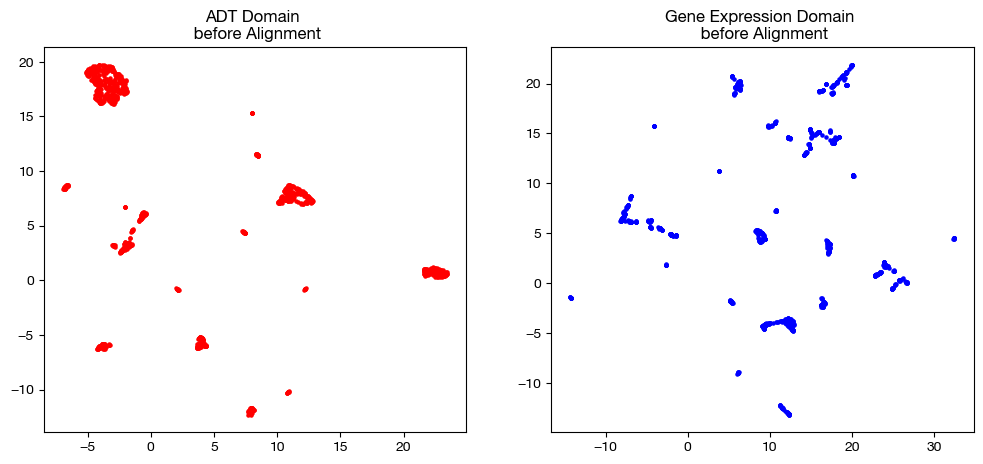

In [4]:
# we fit these objects now, and use them to transform our aligned data later on
adt_um = umap.UMAP(random_state=0, n_jobs=1)
rna_um = umap.UMAP(random_state=0, n_jobs=1)

adt_um.fit(adt.to_numpy())
rna_um.fit(rna.to_numpy())

original_adt_um=adt_um.transform(adt.to_numpy())
original_rna_um=rna_um.transform(rna.to_numpy())

# visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5)
ax1.set_title("ADT Domain \n before Alignment")
ax2.scatter(original_rna_um[:,0], original_rna_um[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n before Alignment")
plt.show()

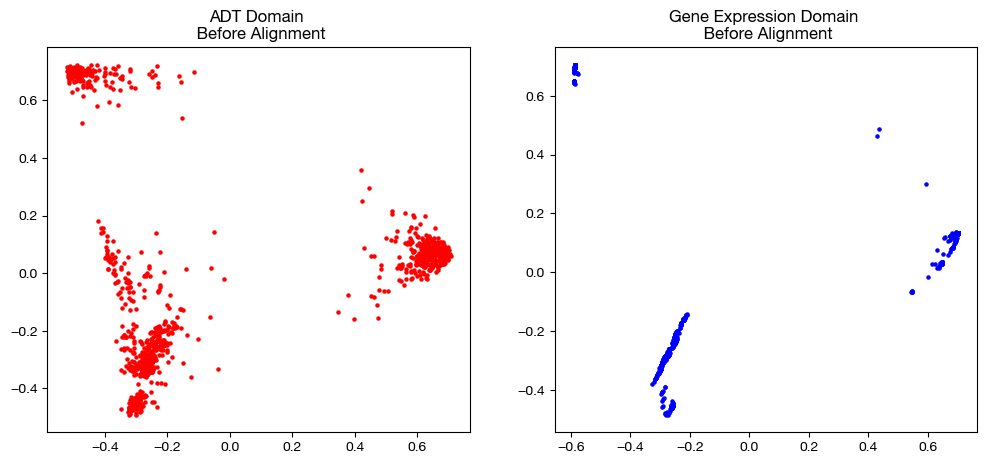

In [5]:
from sklearn.decomposition import PCA

# again, we fit these now so that we can transform our aligned data later on
adt_pca=PCA(n_components=2)
rna_pca=PCA(n_components=2)

adt_pca.fit(adt.to_numpy())
rna_pca.fit(rna.to_numpy())

original_adt_pca=adt_pca.transform(adt.to_numpy())
original_rna_pca=rna_pca.transform(rna.to_numpy())

# visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="r", s=5)
ax1.set_title("ADT Domain \n Before Alignment")
ax2.scatter(original_rna_pca[:,0], original_rna_pca[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n Before Alignment")
plt.show()

### Converting Datasets to Distance Matrices

In this tutorial, we will go over how to use a Solver object to align your data using UGW, starting with balanced scenarios (GW). UGW is a simpler form of UCOOT and AGW, which seeks only to minimize the transport cost for samples, and ignores the problem of aligning features. We can begin by instantiating a Solver object. These parameters (as per setup tutorial) are set to make this notebook run a bit faster, in addition to the fact that the CITEseq data doesn't require quite as many UOT iterations to converge to a nice result.

In [6]:
scot = SinkhornSolver(nits_uot=5000, tol_uot=1e-3, device=device)

In the case of GW, the goal is to generate one coupling matrix that matches samples from one domain to samples of the other. Our GW (and UGW) solver treats the samples of each experiment as a probability distribution (two total distributions) and finds the coupling matrix that determines the most cost-efficient way to move mass from one distribution to the other. So, the GW solver will produce a matrix that determines how much mass of a sample in one domain should go to each sample in the other domain (values stored across each sample's respective row or column). This matrix is then used to project data from one domain into the other.

In order to do this, our solver seeks to minimize the GW cost of transporting the mass of each pair of points to each other pair of points. In particular, for a given $x_a$ and $x_b$ in one domain and a given $y_a$ and $y_b$ in the other domain, the GW cost of transporting $x_a$ and $x_b$ to $y_a$ and $y_b$ is $L(D(x_a, x_b), D(y_a, y_b)) \cdot \pi_{x_a, y_a} \cdot \pi_{x_b, y_b}$, where $L$ is a given cost function (usually squared euclidean distance) and $D$ is some measure of intra-domain distance (in our case, l2 distance or nearest-neighbor connectivity). So, our GW solver seeks to select $\pi$ (or $P$, as we sometimes refer to it) to minimize these costs summed across all pairs of points in each domain. Looking at this cost function, we can see that GW cost penalizes matching a pair of points based on some measure of the difference in pairwise distances; i.e., minimizing GW cost best maintains local geometry. As another way of thinking about it, GW encourages a large $\pi_{xy}$ if $x$ and $y$ have similar "locations" relative to the rest of their domain.

Looking at the cost function again, we can see that GW requires us to know the distance between each pair of points resting in the same domain. In fact, we input these distance matrices to our GW call in order to make our alignments. Let's look at a few different ways we can calculate these distance matrices:

In [7]:
# squared l2 distance
D_adt_l2 = torch.cdist(torch.from_numpy(adt.values), torch.from_numpy(adt.values), p=2)**2
D_rna_l2 = torch.cdist(torch.from_numpy(rna.values), torch.from_numpy(rna.values), p=2)**2

# knn connectivity distance
D_adt_knn, D_rna_knn = torch.from_numpy(compute_graph_distances(adt, n_neighbors=50, mode='connectivity')).to(device), torch.from_numpy(compute_graph_distances(rna, n_neighbors=50, mode='connectivity')).to(device)

### Default GW

Now, we will start with an example of GW using its default parameters, followed by a completed alignment. Note that, to complete an alignment, we must use the produced coupling matrix to project the samples in one domain into the other. Since we use squared euclidean distance to penalize the difference in pairwise distances ($L$ function in the cost in the previous section), this projection, for a given $x_a$ in the domain we are seeking to project, takes the row/column-wise (depending on the orientation of $\pi$) weighted average associated with $x_a$:

$x_a$ projected onto $Y = \frac{\Sigma_{i=1}^{n_y}(y_i*\pi_{x_a,y_i})}{\Sigma_{i=1}^{n_y} (\pi_{x_a,y_i})}$

Once this process is completed for all $x_j$, we recover GW's predicted values for the cells from domain $X$ on the features of domain $Y$. In a separately assayed example (not as trivial like this case), this alignment will give us the measurement for every feature in $X$ and $Y$ on the sample set of $X$ – we have the measured values on $X$'s features and the predicted values on $Y$'s features. Let's see this workflow in action (GW followed by projection) using GW's default parameters (except for a change in $\epsilon$, which we will examine later). Then, we will move on to the two main hyperparameters for this method. Note that for now, we will stick to KNN distance.

In [17]:
# set verbose=True to get a breakdown of the cost progression during optimization
# set log=True to get extra return values, log_cost and log_ent_cost, which display the cost progression
# set early stopping tol to end convergence early based on displayed costs
(pi_samp_1, pi_samp_2, _), log_cost, log_ent_cost = scot.gw(D_rna_knn, D_adt_knn, eps=1e-3, verbose=False, log=True, early_stopping_tol=1e-4)

In the above code, notice that we get back a lot more than just a singular coupling matrix. Since we solve for UGW by isolating a subroutine in our AGW solver (more in the AGW tutorial), we get back three coupling matrices: pi_samp, pi_samp_prime, and pi_feat (which is meaningless and uniform, in this case). If we re-examine the GW cost from above, we can see that $\pi$ is called upon twice: $L(D(x_a, x_b), D(y_a, y_b)) \cdot \pi_{x_a, y_a} \cdot \pi_{x_b, y_b}$. pi_samp_prime is a second copy of pi_samp that we use in place of the second call to $\pi$ in this cost function, which should theoretically converge to pi_samp (given our pairwise transport should be the same, given multiplication is commutative and our sum order over $a$ and $b$ can be switched easily).

The next two results we get are only present if we set log=True. If we were to set log=false, we would only have three values to unpack in the above code. However, if log=True, we also get back a log of the transport cost (log_cost) in addition to the log of the entropic + transport cost (log_ent_cost) as a list. These pairs of costs are what we see printed in the verbose output of GW, labelled "Loss." We will go over entropic cost in the next subsection of this tutorial. For now, we move on to the application of these coupling matrices: alignment.

```{warning}
Be careful how you order your matrices between UGW and alignment. pi_samp will have the samples of the first matrix you input on its vertical axis and the samples of the second matrix you input on its horizontal axis. Our get_barycentre method takes in the anchor domain (the one you want to project onto) and assumes that the anchor domain samples are on the horizontal axis during projection. Therefore, make sure to put your desired anchor domain second in the previous step. So, if we want to project $X$ onto $Y$, (as we are doing in this case), we put $X$ before $Y$ above, and then pass in $Y$ to get_barycentre. We then get back our aligned $X$ (i.e., samples of $X$ by estimated features of $Y$).
```

In [19]:
aligned_rna = get_barycentre(adt, pi_samp_1, device=device)
aligned_rna.shape

torch.Size([1000, 25])

Note also that, since $L$ is a commutative operation, reversing the order in which we input our intra-domain distance matrices will return the exact transpose of sample coupling matrix we just computed (within some small margin of error):

In [20]:
(pi_samp_1_t, pi_samp_2_t, _), log_cost, log_ent_cost = scot.gw(D_adt_knn, D_rna_knn, eps=1e-3, verbose=False, log=True, early_stopping_tol=1e-4)

# the fraction of our original coupling matrix's mass that is assigned
# differently is small
print('Total sum of pi_samp_1: {0}'.format(sum(sum(pi_samp_1))))
print('Total sum of pi_samp_1_t: {0}'.format(sum(sum(pi_samp_1_t))))
print('Total sum of differences: {0}'.format(sum(sum(abs(pi_samp_1 - pi_samp_1_t.T)))))

Total sum of pi_samp_1: 0.9999982714653015
Total sum of pi_samp_1_t: 1.0000001192092896
Total sum of differences: 0.0014336302410811186


From here, we can score the alignment. Note that we generated $X$ and $Y$ such that they contain data on the same set of 1000 cells (co-assayed); this means that, in a perfect alignment, aligned_X would be identical to $Y$. So, we can score aligned_X based on some measure of how close it is to $Y$. To do this, we use FOSCTTM (fraction of samples closer than true match). In order to calculate a score, for each sample $y$ in $Y$, we compute a ranking of how close (l2 distance) each sample in aligned_X is to $y$. From here, we find the index at which the true match for $y$ falls within this sorted ranking. This index tells us how many samples in aligned_X are closer to $y$ than its true match, which is a measure of how well the alignment matched samples in $X$ to $y$. By taking the average of these scores across all $y$, we can get a sense for how good the alignment was. We often average this score with the FOSCTTM in the other direction, i.e. we look at how many samples in $Y$ are closer to each $x$ in aligned_X. The lower the FOSCTTM, the better.

```{note}
In this tutorial, we are not going for perfect alignments; rather, we are trying to get some intuition for how the different parameters modify the alignment. As we learn better how to tune our hyperparameters throughout the course of this core chapter, the alignment scores will gradually improve.
```

Average FOSCTTM score for this alignment with X onto Y is: 0.27175925925925926


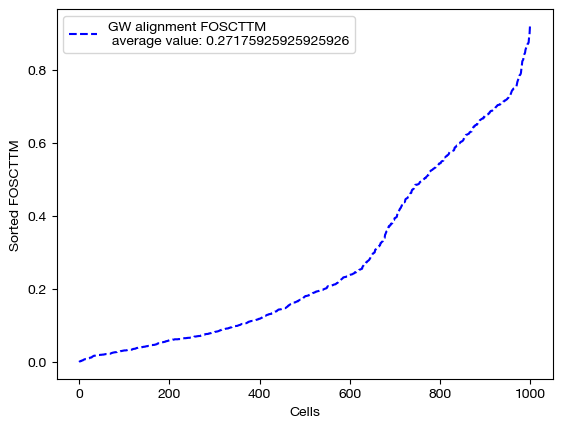

In [11]:
fracs = FOSCTTM(adt, aligned_rna.numpy())
print("Average FOSCTTM score for this alignment with X onto Y is:", np.mean(fracs))
legend_label="GW alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

With the newly aligned data, we can also see how the alignment looks on UMAP and PCA:

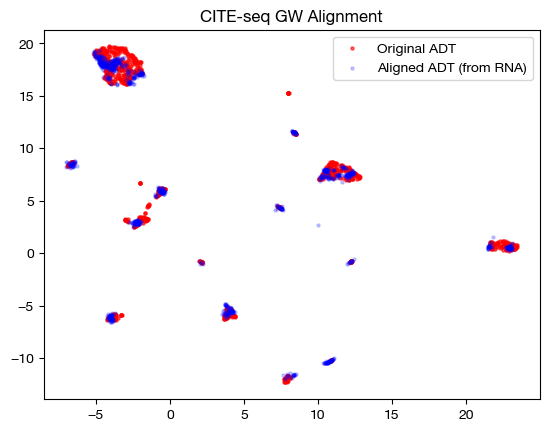

In [12]:
# fit on original two components
original_adt_um=adt_um.transform(adt)
aligned_rna_um=adt_um.transform(aligned_rna.numpy())

plt.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5, alpha=0.6, label="Original ADT")
plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, alpha=0.2, label="Aligned ADT (from RNA)")
plt.legend()
plt.title("CITE-seq GW Alignment")
plt.show()

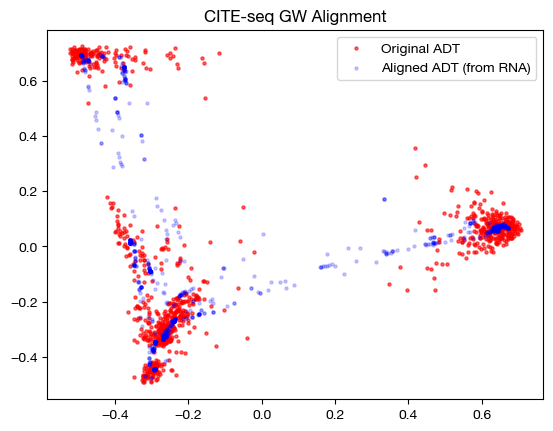

In [152]:
# fit on original two components
original_adt_pca=adt_pca.transform(adt.to_numpy())
aligned_rna_pca=adt_pca.transform(aligned_rna.numpy())

plt.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="r", s=5, alpha=0.6, label="Original ADT")
plt.scatter(aligned_rna_pca[:,0], aligned_rna_pca[:,1], c="b", s=5, alpha=0.2, label="Aligned ADT (from RNA)")
plt.legend()
plt.title("CITE-seq GW Alignment")
plt.show()

Note that the alignments look nice (the shapes match up well). This property does not guarantee a good alignment, as we can see by our somewhat high original FOSCTTM score. In fact, it is more a representation of the sparsity of the coupling matrix – if the coupling matrix is very sparse, it will get close to attempting a 1-1 matching, which could be wrong (even though it is 1-1). Having a coupling matrix that is too sparse can be quite dangerous in cases where there is no underlying 1-1 sample map.

From here, we can examine the coupling matrices themselves to see what they may tell us. Given that these sample matrices are large, rather than graphing them, we will look at the rough distance between the two matrices (total difference between cells):

In [21]:
print('Total sum of pi_samp_1: {0}'.format(sum(sum(pi_samp_1))))
print('Total sum of pi_samp_2: {0}'.format(sum(sum(pi_samp_2))))
print('Total sum of differences: {0}'.format(sum(sum(abs(pi_samp_1 - pi_samp_2)))))

Total sum of pi_samp_1: 0.9999982714653015
Total sum of pi_samp_2: 0.9999977350234985
Total sum of differences: 0.016281310468912125


As we can see, the matrices are quite close; relative to their total size, they don't differ much in how they assign mass. If these matrices converged perfectly, we would see no difference, given the symmetry of the distance matrices we discussed above.

### Entropic Regularization

Now that we have one example done, let's look at how entropic regularization and the $\epsilon$ hyperparameter change the alignment process. In addition to the main part of the cost function as described in the previous section, GW adds an extra cost term measuring the entropy of the coupling matrix multiplied by the hyperparameter $\epsilon$. This means that, for larger values of $\epsilon$, the coupling matrix will have more entropy, meaning it will be more dense (farther from a sparse alignment of samples). In addition, the larger $\epsilon$ is, the faster Sinkhorn's algorithm will converge and produce a cost-minimizing coupling matrix. Let's see these effects in action.

```{warning}
Entropic regularization does not apply to all OT algorithms one might use to solve the inner components of a BCD iteration (referring to a future generic Solver object). Sinkhorn/scaling is an example of an algorithm that depends on entropic regularization, and a common one we use to speed up alignment. However, conditional gradient descent, earth mover's distance, and majorization-minimization (possible future algorithms) all do not require entropic regularization.

Although entropic regularization only applies to a subset of possible OT algorithms, Sinkhorn is the most common method we use for OT iterations (to the point that the following section is warranted).
```

In [22]:
import time

start = time.time()
(pi_samp_sm, _, _), _, log_ent_cost = scot.gw(D_rna_knn, D_adt_knn, eps=1e-4, verbose=False, log=True)
end = time.time()

print(f"Time for low epsilon: {(end - start):0.2f} seconds")

start = time.time()
(pi_samp_med, _, _), _, log_ent_cost = scot.gw(D_rna_knn, D_adt_knn, eps=1e-3, verbose=False, log=True)
end = time.time()

print(f"Time for medium epsilon: {(end - start):0.2f} seconds")

start = time.time()
(pi_samp_lg, _, _), _, log_ent_cost = scot.gw(D_rna_knn, D_adt_knn, eps=1e-1, verbose=False, log=True)
end = time.time()

print(f"Time for high epsilon: {(end - start):0.2f} seconds")

Time for low epsilon: 105.10 seconds
Time for medium epsilon: 8.28 seconds
Time for high epsilon: 0.12 seconds


Note the decreasing length of time to converge. The longer time to converge for lower $\epsilon$ indicate that more iterations were required for convergence to an optimal coupling matrix. This result indicates that larger values of $\epsilon$ do help with faster convergence. Now, let's align the data and examine the FOSCTTM scores for each alignment:

In [23]:
aligned_rna_sm = get_barycentre(adt, pi_samp_sm)
aligned_rna_med = get_barycentre(adt, pi_samp_med)
aligned_rna_lg = get_barycentre(adt, pi_samp_lg)

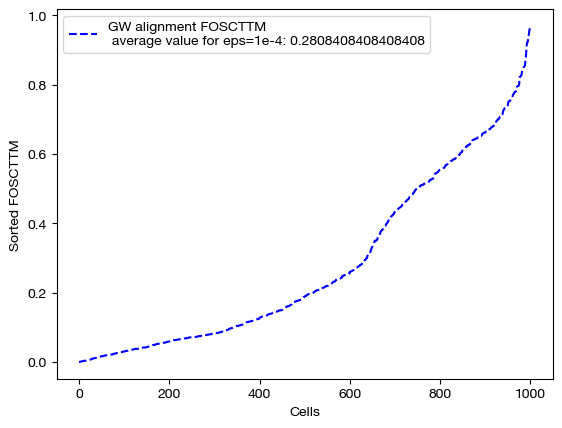

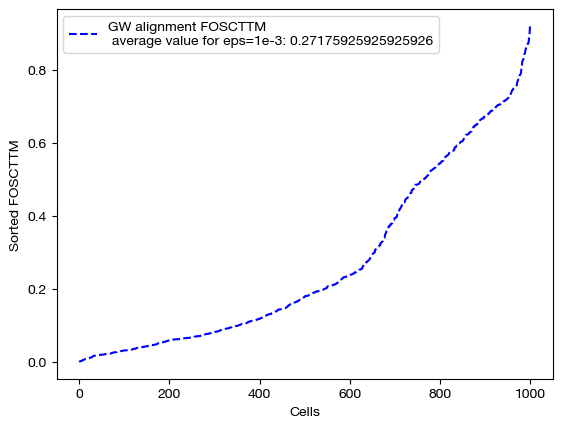

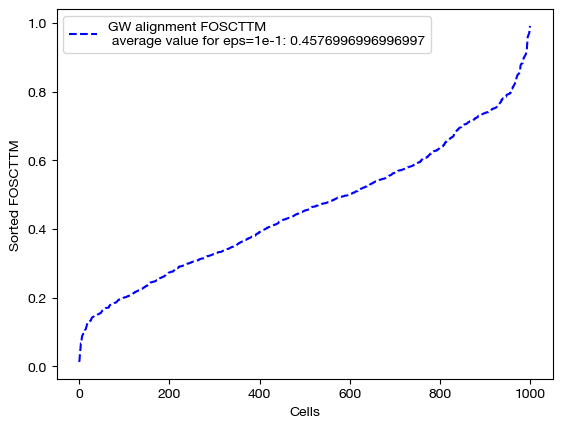

In [24]:
for aligned_rna, size in [(aligned_rna_sm, 'eps=1e-4'), (aligned_rna_med, 'eps=1e-3'), (aligned_rna_lg, 'eps=1e-1')]:
    fracs = FOSCTTM(adt, aligned_rna.numpy())
    legend_label="GW alignment FOSCTTM \n average value for {0}: ".format(size)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

Note that a smaller value of $\epsilon$ does not necessarily guarantee better alignment quality. In fact, since smaller $\epsilon$ encourages sparsity, it could lead to the sparsity pitfalls (confidently incorrect matchings) we looked at earlier in this section. To find the $\epsilon$ best for your particular data, you can do a search of a given log space:

In [25]:
# an example of epsilon search
pi_samp_dt = {}
# for val in np.logspace(start=-4, stop=-1, num=10):
    # (pi_samp_dt[val], _) = scot.gw(Dx_knn, Dy_knn, eps=val)

From here, we will continue our investigation of $\epsilon$ by visualizing the data. We will start with the three coupling matrices.

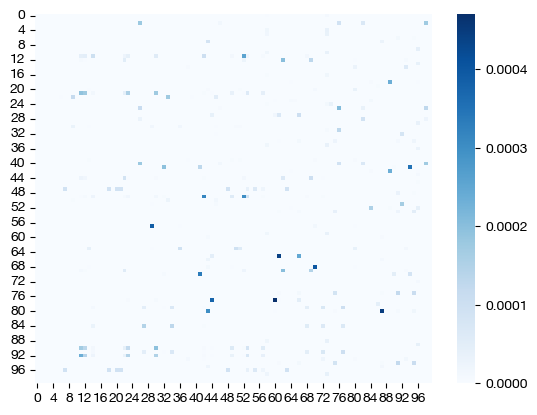

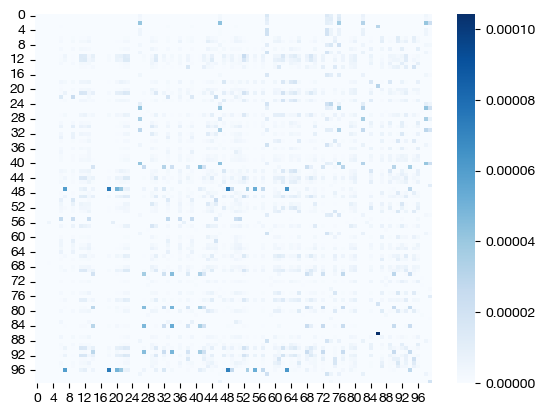

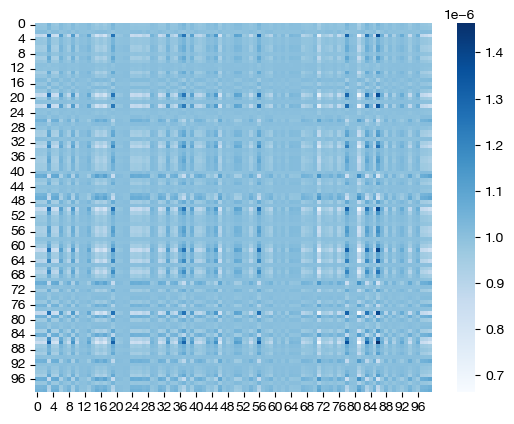

In [26]:
for pi_samp, size in [(pi_samp_sm, 'eps=1e-4'), (pi_samp_med, 'eps=1e-3'), (pi_samp_lg, 'eps=1e-1')]:
    # note that we look at a corner of the coupling matrix as a proxy to look at density    
    sns.heatmap(pi_samp[:100,:100], cmap='Blues')
    plt.show()

Note how, for the larger value of $\epsilon$, we get a much more dense coupling matrix. This result is as we expected: larger $\epsilon$ places a larger emphasis on minimizing entropy via our cost function. Let's see what these different coupling matrices mean for our UMAP visualization:

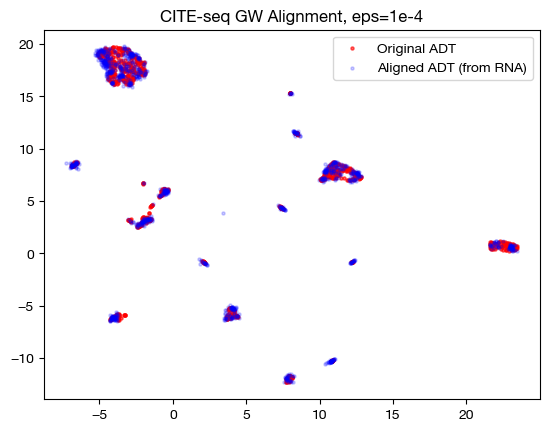

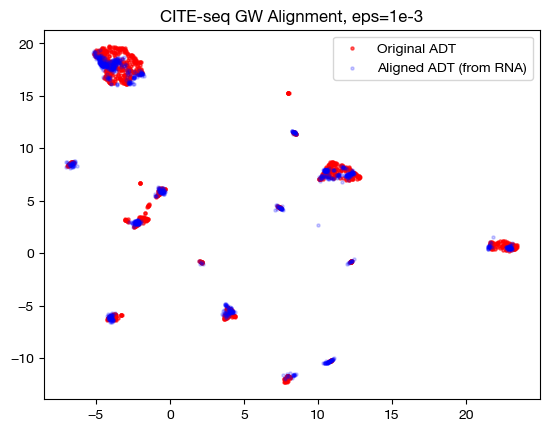

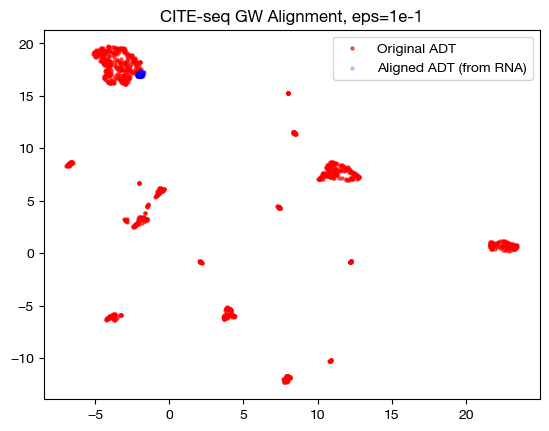

In [172]:
for aligned_rna, size in [(aligned_rna_sm, 'eps=1e-4'), (aligned_rna_med, 'eps=1e-3'), (aligned_rna_lg, 'eps=1e-1')]:    

    aligned_rna_um=adt_um.transform(aligned_rna.numpy())

    plt.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5, alpha=0.6, label="Original ADT")
    plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, alpha=0.2, label="Aligned ADT (from RNA)")
    plt.legend()
    plt.title("CITE-seq GW Alignment, {0}".format(size))
    plt.show()

In the low $\epsilon$ case, we see a near 1-1 alignment (remember, this near 1-1 is likely mapping wrong cells to wrong cells in many cases) in UMAP, which is consistent with the sparse coupling matrix. As we raise $\epsilon$ to the medium case, we start to see some deviation from 1-1 alignment, and in the large $\epsilon$ case, we see something completely different. To see what is really happening in this large $\epsilon$ case, let's try linear dimensionality reduction:

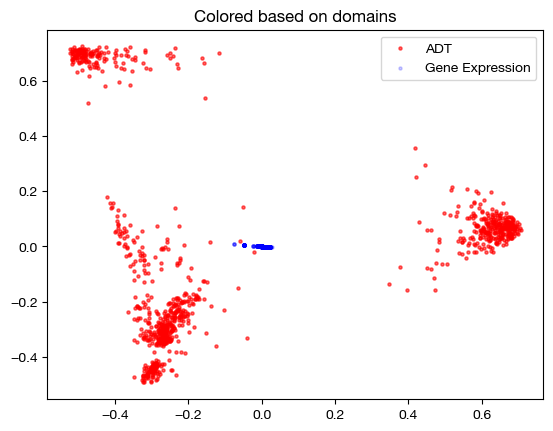

In [173]:
aligned_rna_pca=adt_pca.transform(aligned_rna.numpy())

plt.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="r", s=5, alpha=0.6, label="ADT")
plt.scatter(aligned_rna_pca[:,0], aligned_rna_pca[:,1], c="b", s=5, alpha=0.2, label="Gene Expression")
plt.legend()
plt.title("Colored based on domains")
plt.show()

As we can see, the projected data has little to no variance with respect to the principal components of our anchor domain. We can interpret this to mean that every point in the domain being projected was projected to an average of every point in the anchor domain; since the coupling matrix was so dense, projection just led to a weighted average of points where the weights were much closer to even. So, $\epsilon$ too high and too low both have their setbacks.

```{tip}
Note that the $\epsilon$ that produces the best alignment scores on co-assayed data like this will not necessarily generalize to separate assay data; finding a good $\epsilon$ will vary case by case.
```

We can also demonstrate that the "entropic_mode" parameter doesn't matter for UGW; the distinction between 'joint' and 'independent' comes in when we are hoping to regularize coupling matrices separately, which is not the case for UGW (where we expect our coupling matrices to be similar upon convergence). See our UCOOT tutorial for more detail on this parameter. See the following for an example of how they do not differ:

In [27]:
pi_samp_ind, _, _ = scot.gw(D_rna_knn, D_adt_knn, eps=1e-3, entropic_mode="independent", verbose=False)

pi_samp_jnt, _, _ = scot.gw(D_rna_knn, D_adt_knn, eps=1e-3, entropic_mode="joint", verbose=False)

In [28]:
torch.sum(pi_samp_ind), torch.sum(abs(pi_samp_ind - pi_samp_jnt))

(tensor(1.), tensor(7.7564e-05))

Now, we will move onto a different hyperparameter. The key takeaway from this section is that increasing $\epsilon$ trades better runtime for less sparsity.

### Marginal Relaxation

With a general understanding of what $\epsilon$ is doing, let's now examine the $\rho$ hyperparameter. At this point, we move from balanced GW (our gw function) to unbalanced GW (our ugw function). As an argument to the UGW solver, $\rho$ will be a tuple of two values; $\rho_x$ relates to the samples in $X$, while $\rho_y$ relates to the samples in $Y$. Recall that UGW treats the samples in both domains as probability distributions and decides how to move mass from one distribution to the other, producing a coupling matrix. $\rho_x$ and $\rho_y$ determine how close the coupling matrix sticks to these distributions; they determine, in some sense, how close the marginals of the coupling distribution will be to these original distributions.

Specifically, $\rho_x$ and $\rho_y$ are multiplied by respective terms that measure (in terms of KL divergence) how close the desired distribution is to the marginals of the coupling matrix. So, the larger either $\rho$ is, the closer its respective desired distribution will be to the marginals of the coupling matrix, as there will be a higher cost to differences between the distributions. In fact, we used $\rho$ = infty in the previous examples; this forces the marginals of the coupling matrix to exactly match the desired distributions (otherwise incurring a cost of infinity). Allowing $\rho$ to decrease below infinity leads to what we might call an "unbalancing" in the initial distributions, as we allow some samples to transport more or less mass than they were originally allocated. This is why we now use UGW instead of GW – the U stands for unbalanced. Let's look at how UGW works, first on a fairly balanced set of data:

In [176]:
pi_samp, _, _ = scot.ugw(D_rna_knn, D_adt_knn, eps=1e-3, rho=(0.1,0.1), verbose=False)
aligned_rna = get_barycentre(adt, pi_samp)

We can start by scoring this alignment:

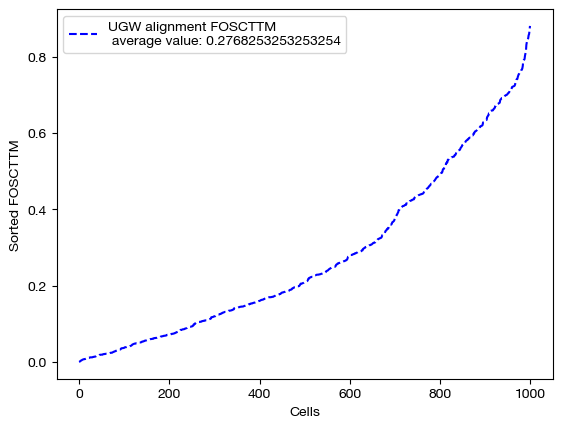

In [177]:
fracs = FOSCTTM(adt, aligned_rna.numpy())
legend_label="UGW alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

And visualizing it:

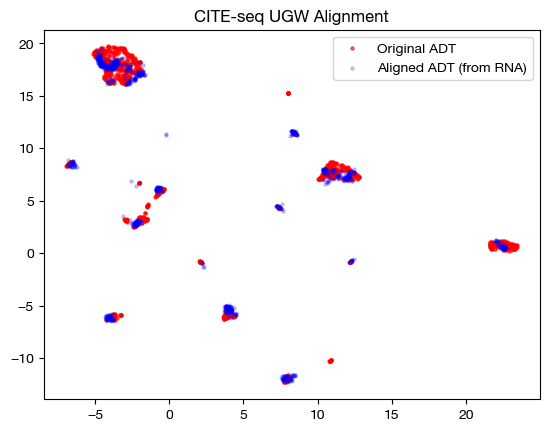

In [180]:
aligned_rna_um=adt_um.transform(aligned_rna.numpy())

plt.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5, alpha=0.6, label="Original ADT")
plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, alpha=0.2, label="Aligned ADT (from RNA)")
plt.legend()
plt.title("CITE-seq UGW Alignment")
plt.show()

However, we can only truly get a window into $\rho$ by looking at the coupling matrix. In the uniform marginal case, which we got with GW, each row would have the same sum, $\frac{1}{1000}$. With our new unbalancing, this is no longer the case:

In [181]:
print('Unbalanced coupling matrix: ')
for i in range(5):
    print(pi_samp[i].sum())
print('\nBalanced coupling matrix: ')
for i in range(5):
    print(pi_samp_ind[i].sum()) # a coupling matrix from earlier, that was balanced

Unbalanced coupling matrix: 
tensor(0.0009)
tensor(0.0009)
tensor(0.0009)
tensor(0.0008)
tensor(0.0009)

Balanced coupling matrix: 
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)


In our case, where we have 1000 cells without disproportionate cell type representation across domains, unbalancing these distributions doesn't make much sense. However, if we were to have 50 cells of cell type 1 and 950 of cell type 2 in domain 1, and 500 of each in domain 2, we would want those 50 cells in domain 1 to transport much more mass. By allowing this to happen, $\rho$ makes UGW much more robust to outliers and underrepresented cell types. Note that this disproportionate example would only really happen with separately assayed datasets.

Let's see how unbalancing can help by taking 90 cells from smaller clusters in the RNA-seq data and 10 cells from a larger cluster. We would naively expect these 10 cells to transport more mass with $\rho$ < infinity. We can begin by isolating one large cluster in the data, which we found by searching over k (and settling on k = 50) using a kneighbors graph.

In [87]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components

rna_graph = kneighbors_graph(original_rna_pca, 50, mode='connectivity', include_self=True)

k, labels = connected_components(rna_graph, directed=False)
labels = pd.Series(labels)
labels.value_counts()

0    503
1    335
2    162
Name: count, dtype: int64

As we can see, k = 50 gives us 3 different connected clusters on the k neighbors graph. We will treat the 0 labelled cluster as our large cluster, and sample 10 from that pool; we will treat the rest as smaller clusters, and sample 90:

In [88]:
sm_clust = labels.loc[labels != 0]
lg_clust = labels.loc[labels == 0]

sm_clust_smpl = sm_clust.sample(n=90, random_state=0)
lg_clust_smpl = lg_clust.sample(n=10, random_state=0)

rna_sm = rna.iloc[sm_clust_smpl.index]
rna_lg = rna.iloc[lg_clust_smpl.index]

rna_new = pd.concat((rna_lg, rna_sm), axis=0)

We can look at the samples we ended up drawing in the graph below, in the target domain (note that we use these samples in the source/RNA domain when aligning, but this is where they should end up):

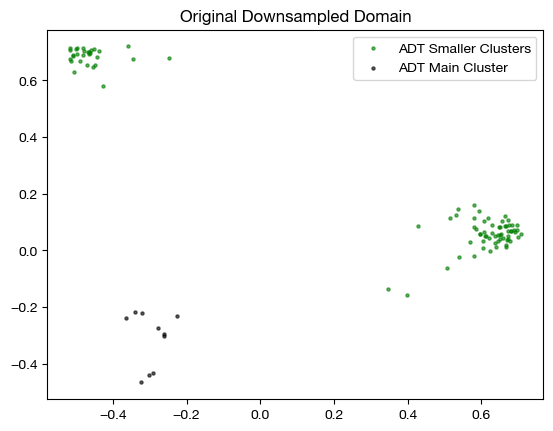

In [89]:
plt.scatter(original_adt_pca[sm_clust_smpl.index.values,0], original_adt_pca[sm_clust_smpl.index.values,1], c="g", s=5, alpha=0.6, label="ADT Smaller Clusters")
plt.scatter(original_adt_pca[lg_clust_smpl.index.values,0], original_adt_pca[lg_clust_smpl.index.values,1], c="k", s=5, alpha=0.6, label="ADT Main Cluster")
plt.legend()
plt.title("Original Downsampled Domain")
plt.show()

This process has given us a new version of our gene expression domain, which we will align with our original ADT domain. We expect that the top ten rows of the coupling matrix will transport more mass with $\rho$ < infty. Now, we can try an alignment; however, we first need a distance matrix for our new $Y$:

In [90]:
D_rna_knn_new = torch.from_numpy(compute_graph_distances(rna_new, n_neighbors=50, mode='connectivity')).to(device)

Now, we can align:

In [91]:
pi_samp_u, _, _ = scot.ugw(D_rna_knn_new, D_adt_knn, eps=1e-3, rho=(0.1, 0.1), verbose=False)
pi_samp_ctrl, _, _ = scot.ugw(D_rna_knn_new, D_adt_knn, eps=1e-3, rho=(float('inf'), float('inf')), verbose=False)

From here, we can examine the coupling matrices – we care less about alignment quality and scoring for now, considering we now have an unbalanced case. First, let's look at a heatmap:

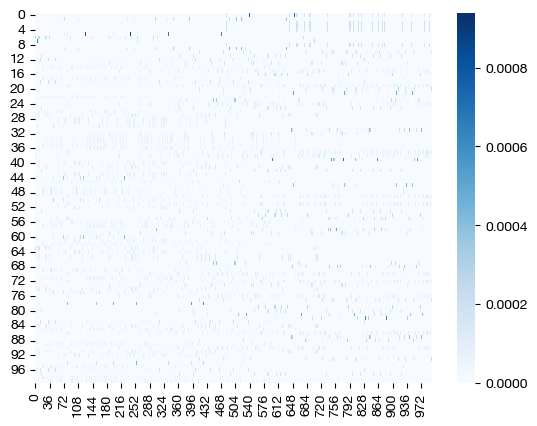

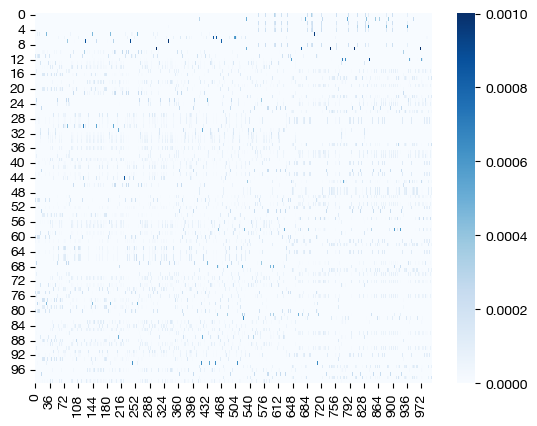

In [81]:
for pi_samp in pi_samp_u, pi_samp_ctrl:
    sns.heatmap(pi_samp, cmap='Blues')
    plt.show()

And our projections:

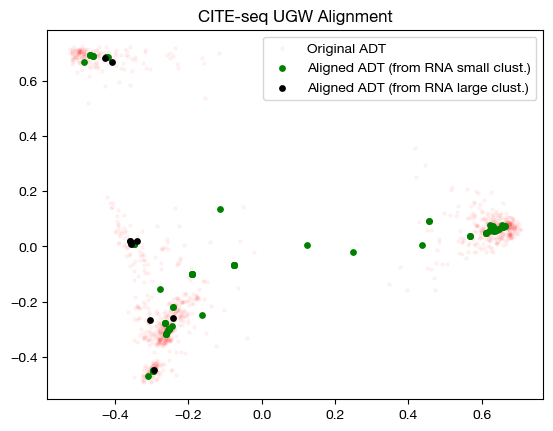

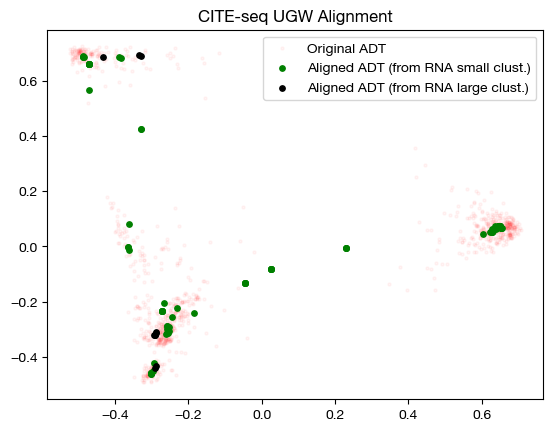

In [92]:
for pi_samp in pi_samp_ctrl, pi_samp_u:
    aligned_rna = get_barycentre(adt, pi_samp)
    aligned_rna_pca = adt_pca.transform(aligned_rna.numpy())
    plt.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="r", s=5, alpha=0.04, label="Original ADT")
    plt.scatter(aligned_rna_pca[10:,0], aligned_rna_pca[10:,1], c="g", s=15, label="Aligned ADT (from RNA small clust.)")
    plt.scatter(aligned_rna_pca[:10,0], aligned_rna_pca[:10,1], c="k", s=15, label="Aligned ADT (from RNA large clust.)")
    plt.legend()
    plt.title("CITE-seq UGW Alignment")
    plt.show()

The heatmap visualization is not so easy to grasp; however, the alignment suggests that UGW did a reasonable job keeping large cluster samples in the large cluster, but not as well keeping small cluster samples in their small clusters (we see a concentration of green in the bottom left). If we look at the column-wise sums, we can see exactly how unbalanced the coupling matrices are:

In [93]:
torch.sum(pi_samp_ctrl, axis=1)[:10], torch.mean(torch.sum(pi_samp_ctrl, axis=1))

(tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100]),
 tensor(0.0100))

In [94]:
torch.sum(pi_samp_u, axis=1)[:10], torch.mean(torch.sum(pi_samp_u, axis=1))

(tensor([0.0078, 0.0065, 0.0075, 0.0076, 0.0074, 0.0062, 0.0083, 0.0073, 0.0075,
         0.0066]),
 tensor(0.0087))

Looking at this under our naive hypothesis that the large cluster samples would transport more mass than small cluster samples, the above doesn't seem quite right – why are the masses of the large cluster samples so far below the mean for the mass transported by the RNA domain axis? To get a sense for what happened, we can look at a confusion matrix (i.e., how much mass was transported from large cluster samples to large cluster samples, small to small, etc.).

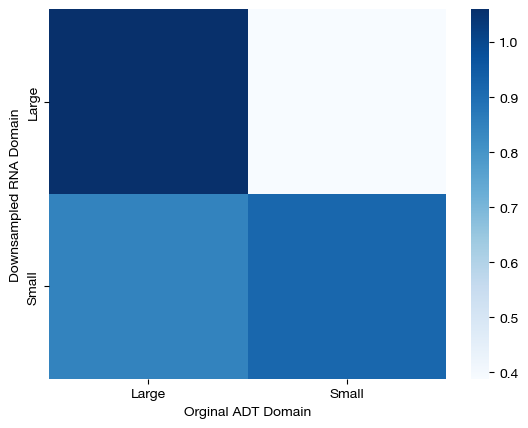

In [95]:
# note that we normalize by the expected amount of mass at each cell, for more interpretable numbers
conf_mtx = np.zeros((2,2))
conf_mtx[0,0] = (torch.mean(pi_samp_u[:10, lg_clust.index.values])*1e5).item()
conf_mtx[1,1] = (torch.mean(pi_samp_u[10:, sm_clust.index.values])*1e5).item()
conf_mtx[0,1] = (torch.mean(pi_samp_u[:10, sm_clust.index.values])*1e5).item()
conf_mtx[1,0] = (torch.mean(pi_samp_u[10:, lg_clust.index.values])*1e5).item()
sns.heatmap(pd.DataFrame(conf_mtx, index=["Large","Small"], columns=["Large", "Small"]), cmap='Blues')
plt.xlabel("Orginal ADT Domain")
plt.ylabel("Downsampled RNA Domain")
plt.show()

Here, we can see that large samples from the downsampled domain transport virtually all of their mass to large samples in the original ADT domain, but our solver experienced significantly more confusion transporting mass from small cluster samples to small cluster samples in the original domain. As a result, we found that large cluster samples in the downsampled domain transported more mass because our solution was less confused for such samples. In a perfect world, the bottom left square would be white, and as such, we would find that large cluster samples transport the same, if not more, mass than small cluster samples. However, note that our solution still does a reasonable job at aligning samples, despite this issue:

In [96]:
np.mean(FOSCTTM(adt.loc[rna_new.index.values], aligned_rna))

0.3921212121212121

### Conclusion

Now that we have gone through all of the most important pieces of how to run UGW on your own data, you can move onto our fused formulation or UCOOT tutorial. The fused formulation helps incorporate prior knowledge into the UGW/UCOOT procedures.

Citations:

Quang Huy Tran, Hicham Janati, Nicolas Courty, Rémi Flamary, Ievgen Redko, Pinar Demetci and Ritambhara Singh. Unbalanced CO-Optimal Transport. arXiv, stat.ML, 2023.